<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/2_updated_Cross_Sectional_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-Sectional Momentum - Updated 2023

In this notebook we do factor analysis on simple momentum factors using our new Coincodex data set.

We find a strong reversal effect when we use this data set - which is the opposite of what we found in our original research.  

We also find that when you put a day between the calculation of the momentum feature and the return, you get a result that starts to resemble our original research, but is still not quite the same.

It's possible that the timing of the daily price snapshot in our new data set could explain this - if so, that would be interesting.  

To find out, we'll next repeat this analyis using the hourly binance data with daily snapshots taken at different times.

## Load libraries and authenticate

In [38]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', 'RcppRoll', 'QuantTools'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘QuantTools’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message in pacman::p_load(char = libs_to_load, install = FALSE):
“Failed to install/load:
QuantTools”


In [39]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Load Coincodex daily data

In [40]:
# snippet: rw crypto load coincodex data v0.1
prices <- rwRtools::crypto_get_coincodex()
prices %>%
  head()

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


Ticker,Date,Price,Volume,MarketCapUSD
<chr>,<date>,<dbl>,<dbl>,<dbl>
BTCD,2017-01-01,3.500750e+00,2.141424e+03,4.513253e+06
TGC,2017-01-01,3.355230e-04,1.809028e+01,1.461090e+04
ATOM,2017-01-02,1.210969e-02,5.763597e+03,9.059482e+04
BTC,2017-01-02,1.016241e+03,1.871437e+08,1.634320e+10
BTCD,2017-01-02,3.389330e+00,2.864861e+03,4.516087e+06
DASH,2017-01-02,1.156342e+01,3.853539e+06,8.113380e+07


# Creating research universe

See Notebook 1 for details on how we construct the universe.

In [41]:
# snippet: rw crypto flag universe consituents v0.2
create_universe <- function(prices, n=10, min_constituents=10, stables, duplicates) {
  # Remove stablecoins and duplicates
  prices <- prices %>%
    filter(!Ticker %in% c(stables, duplicates))

  # Fix bad BCH data
  # 1. make a dataframe of updated rows
  updated_rows <- prices %>%
    filter(Ticker == "BCH") %>%
    # find rows where the price today is more than twice the price from the day before and from the day after
    mutate(
      lag_price = dplyr::lag(Price),
      lead_price = dplyr::lead(Price)
    ) %>%
    filter(
      # 0.65 found by trial and error to isolate the rows we want to ditch
      lag_price < 0.65*Price,
      lead_price < 0.65*Price
    ) %>%
    # set today's price to half way between yesterday's and tomorrow's price
    mutate(Price = lag_price + (lead_price - lag_price)/2) %>%
    # select only the columns that were in our original prices dataframe
    select(Ticker, Date, Price, Volume, MarketCapUSD)

  # 2. remove the bad rows from our original prices dataframe
  prices <- prices %>%
    filter(!(Ticker == "BCH" & Date %in% (updated_rows %>% pull(Date))))

  # 3. merge our prices dataframe with our updated rows and sort
  prices <- prices %>%
    bind_rows(updated_rows) %>%
    arrange(Date, Ticker)

  # Fix dates where something went wrong with the data
  # 1. Get weird dates
  weird_dates <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    mutate(lag_count = dplyr::lag(count)) %>%
    filter(count < 0.8*lag_count) %>%
    pull(Date)

  # 2. Create new dataframe from the dates prior to our weird dates, then label them as our weird dates
  prices_new <- prices %>%
    filter(Date %in% as.Date(weird_dates - 1)) %>%
    mutate(Date = Date + 1)

  # 3. Filter out these weird rows
  prices <- prices %>%
    filter(!Date %in% as.Date(weird_dates))

  # 4. Combine the two dataframes
  prices <- prices %>%
    bind_rows(prices_new) %>%
    arrange(Date, Ticker)

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  prices %>%
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= 10 & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}


# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

duplicates <-  c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC')

# create universe
universe <- create_universe(prices, n=10, min_constituents=10, stables=stables, duplicates=duplicates)

universe %>% head

Ticker,Date,Price,Volume,MarketCapUSD,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
TGC,2017-01-01,3.355230e-04,1.809028e+01,1.461090e+04,1,FALSE
ATOM,2017-01-02,1.210969e-02,5.763597e+03,9.059482e+04,23,FALSE
BTC,2017-01-02,1.016241e+03,1.871437e+08,1.634320e+10,1,FALSE
DASH,2017-01-02,1.156342e+01,3.853539e+06,8.113380e+07,7,FALSE
DCR,2017-01-02,4.702788e-01,5.507167e+03,1.638005e+06,20,FALSE
DGB,2017-01-02,2.584741e-04,1.727275e+04,2.012658e+06,19,FALSE


# Create Momentum Feature and Forward Returns

Calculate 20 day momentum factor and next day returns.

In [42]:
returns <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate 20d momentum feature
  mutate(
    momo20 = Price / lag(Price, n = 20) - 1,
    lagmomo20 = lag(momo20)
  ) %>%
  # Calculate next day returns
  mutate(
    fwd_log_return = log(lead(Price) / Price),
    fwd_simple_return = lead(Price) / Price - 1
  ) %>%
  na.omit() %>%
  ungroup()

  returns %>% head(10)

Ticker,Date,Price,Volume,MarketCapUSD,cap_rank,is_index,momo20,lagmomo20,fwd_log_return,fwd_simple_return
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
TGC,2017-01-22,9.873200e-05,0.000,4.375471e+03,25,FALSE,-0.71602409,-0.69926058,0.343789954,0.410282381
ATOM,2017-01-23,2.970120e-03,166.441,2.777861e+04,23,FALSE,-0.72639590,-0.70591377,0.407604146,0.503211991
BTC,2017-01-23,9.221646e+02,93124419.164,1.487830e+10,1,TRUE,-0.10430563,-0.07745802,-0.012259185,-0.012184348
DASH,2017-01-23,1.513292e+01,1798313.194,1.067052e+08,7,TRUE,0.22041721,0.34233602,-0.048373884,-0.047222508
DCR,2017-01-23,9.737014e-01,20556.387,3.547904e+06,19,FALSE,1.09498312,0.80707257,0.080646229,0.083987345
DGB,2017-01-23,2.702204e-04,21738.042,2.136803e+06,20,FALSE,-0.29854436,-0.01282570,-0.016859855,-0.016718523
DOGE,2017-01-23,2.067551e-04,60343.285,2.203901e+07,11,FALSE,-0.08450945,-0.08437431,0.012042477,0.012115279
ETC,2017-01-23,1.381039e+00,1214589.469,1.221465e+08,6,TRUE,-0.07586702,0.04566183,0.017201068,0.017349858
ETH,2017-01-23,1.075004e+01,8074103.194,9.482876e+08,2,TRUE,0.20316647,0.28661700,-0.008547723,-0.008511296


# Analyzing The 20 day momentum factor

Each day:
 - Rank each coin by its 20 day momentum
 - Group by rank
 - Plot the mean next day log return for each rank.

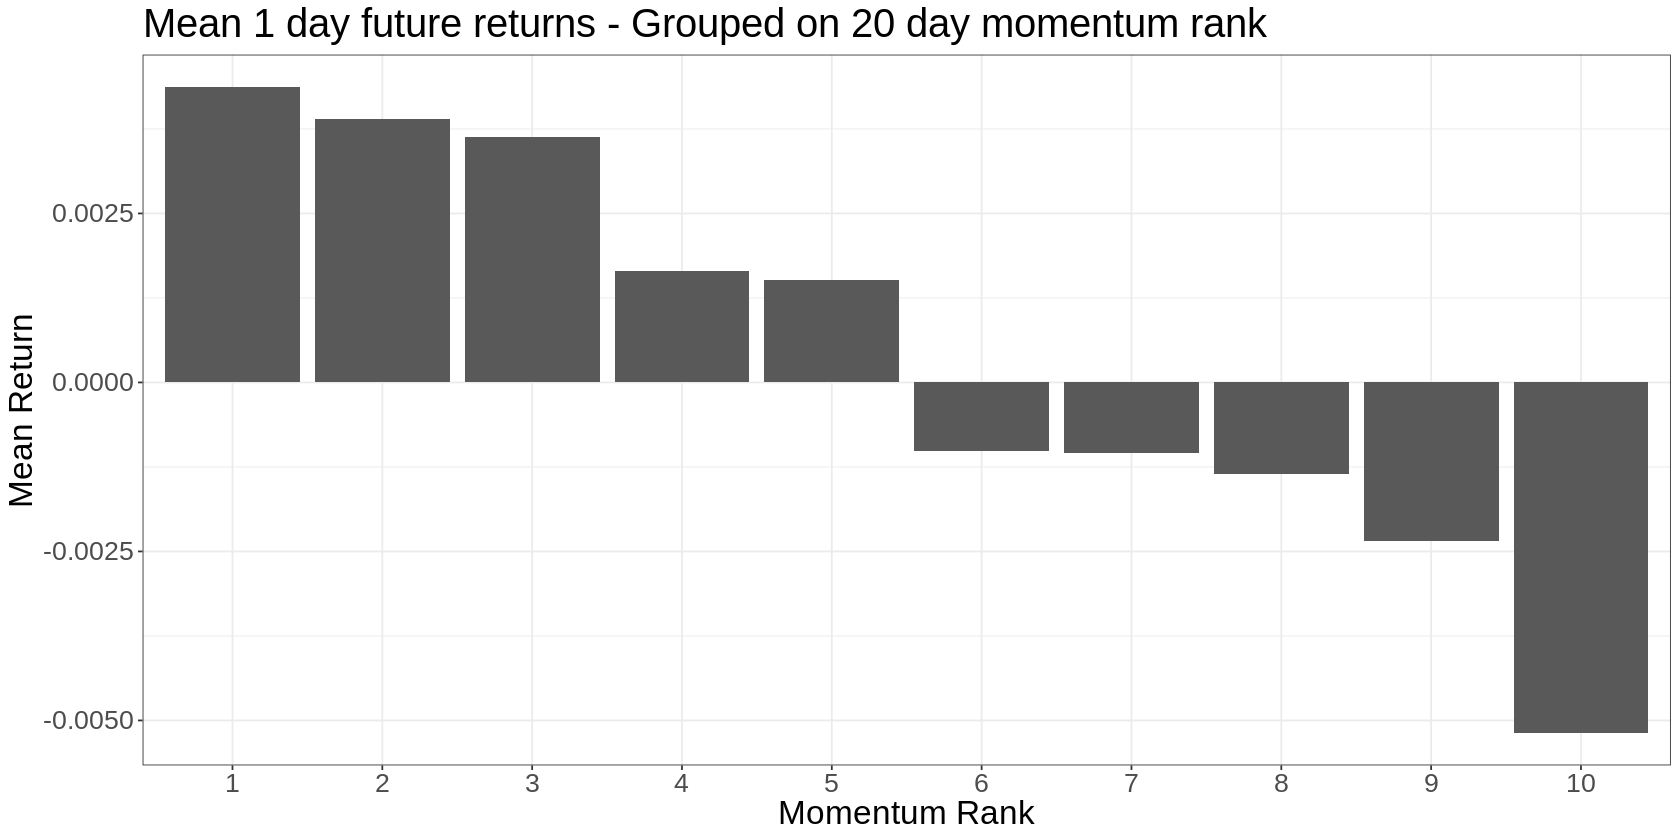

In [43]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(momo20))) %>%
  group_by(rank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=rank, y=mean_fwd_log_ret)) +
  geom_bar(stat='identity') +
  labs(
    title = 'Mean 1 day future returns - Grouped on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

This looks quite different to our original coinmetrics data!! Clear reversal effect.

Let's plot this separately for each year in our sample.

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


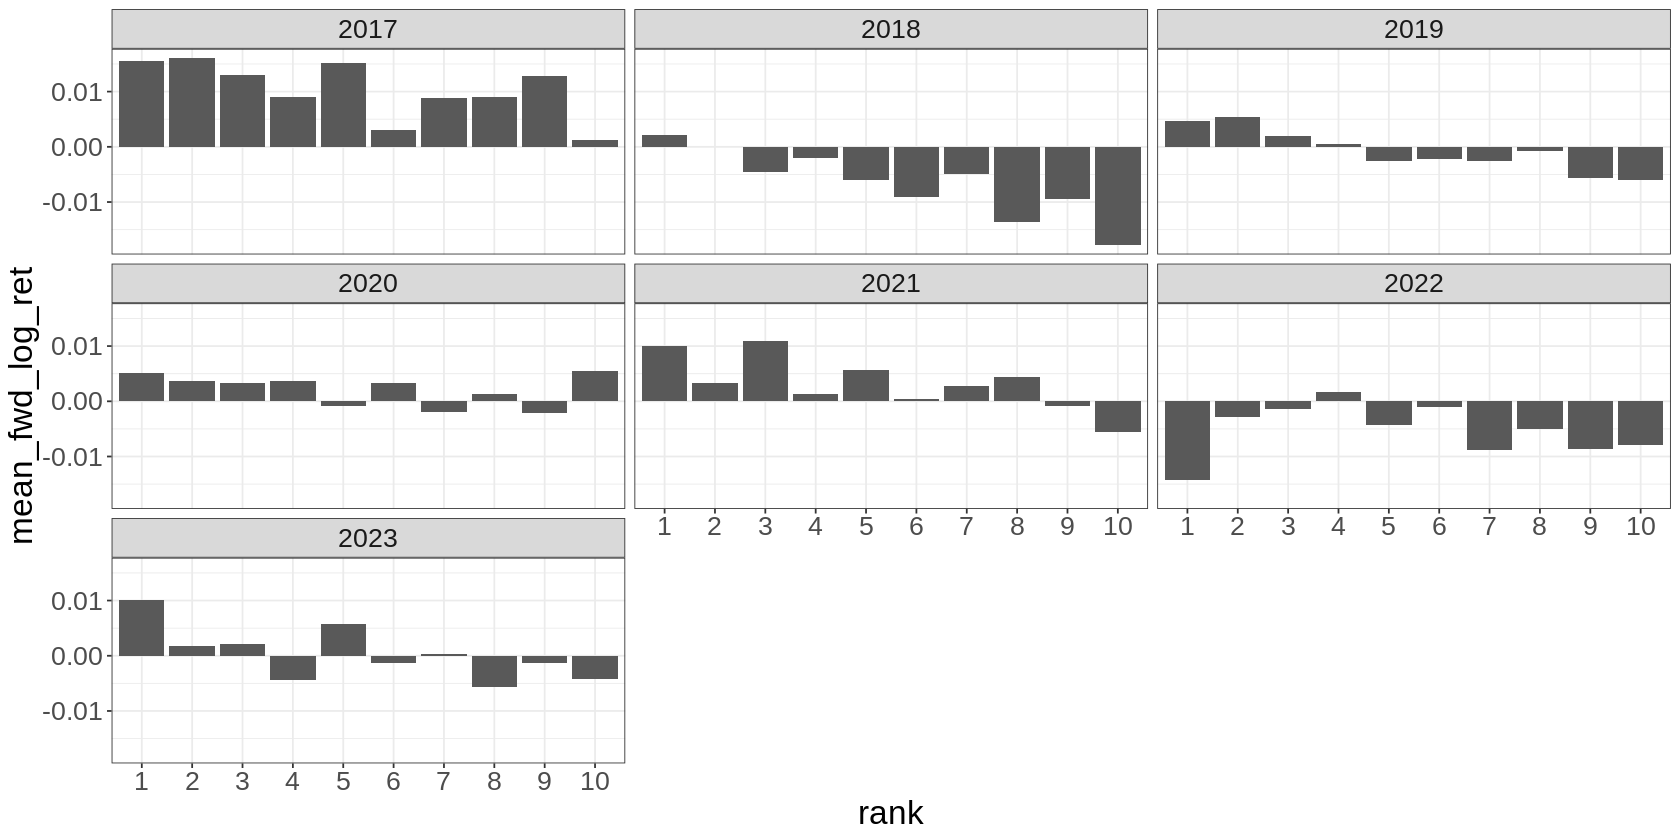

In [44]:
returns %>%
  mutate(year = factor(year(Date))) %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(momo20))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_ret))  +
    geom_bar(stat='identity') +
    facet_wrap(~year)

To make this easier to interpret, let's demean our return target - so we're plotting the relative outperformance rather than absolute outperformance.

In [45]:
demeaned_returns <- returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(
    demeaned_fwd_log_return = fwd_log_return - mean(fwd_log_return),
    demeaned_fwd_simple_return = fwd_simple_return - mean(fwd_simple_return)
  )

demeaned_returns %>% tail(10)

Ticker,Date,Price,Volume,MarketCapUSD,cap_rank,is_index,momo20,lagmomo20,fwd_log_return,fwd_simple_return,demeaned_fwd_log_return,demeaned_fwd_simple_return
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADA,2023-09-04,2.594103e-01,260154076,8681565430,6,TRUE,-0.098370408,-0.125094740,-0.009835564,-0.009787353,-0.005770039,-0.0062199730
BNB,2023-09-04,2.162002e+02,534625610,33067397031,3,TRUE,-0.095375674,-0.108822514,-0.006442100,-0.006421394,-0.002376575,-0.0028540136
BTC,2023-09-04,2.590030e+04,25984900685,504435116809,1,TRUE,-0.117421951,-0.122237968,-0.006260603,-0.006241046,-0.002195078,-0.0026736662
DOGE,2023-09-04,6.231225e-02,1018530083,8891822855,5,TRUE,-0.152228963,-0.152339921,0.030751834,0.031229556,0.034817359,0.0347969359
ETH,2023-09-04,1.637738e+03,5745959771,196884258309,2,TRUE,-0.109340025,-0.106050552,-0.002893385,-0.002889203,0.001172140,0.0006781768
LTC,2023-09-04,6.498690e+01,750774080,4719991010,10,TRUE,-0.207465625,-0.223707257,-0.027114889,-0.026750580,-0.023049364,-0.0231832000
SOL,2023-09-04,1.960209e+01,1736373823,8011822123,7,TRUE,-0.224511969,-0.208146301,0.047691868,0.048847422,0.051757393,0.0524148027
TONCOIN,2023-09-04,1.935911e+00,23169259,6499686530,9,TRUE,0.319679430,0.296225320,-0.071916128,-0.069391055,-0.067850603,-0.0658236748
TRX,2023-09-04,7.666937e-02,3989857546,7142135440,8,TRUE,-0.008765566,-0.005848263,0.021601794,0.021836802,0.025667319,0.0254041821


If we've done this right, then the sum of the demeaned returns for all dates should be zero.

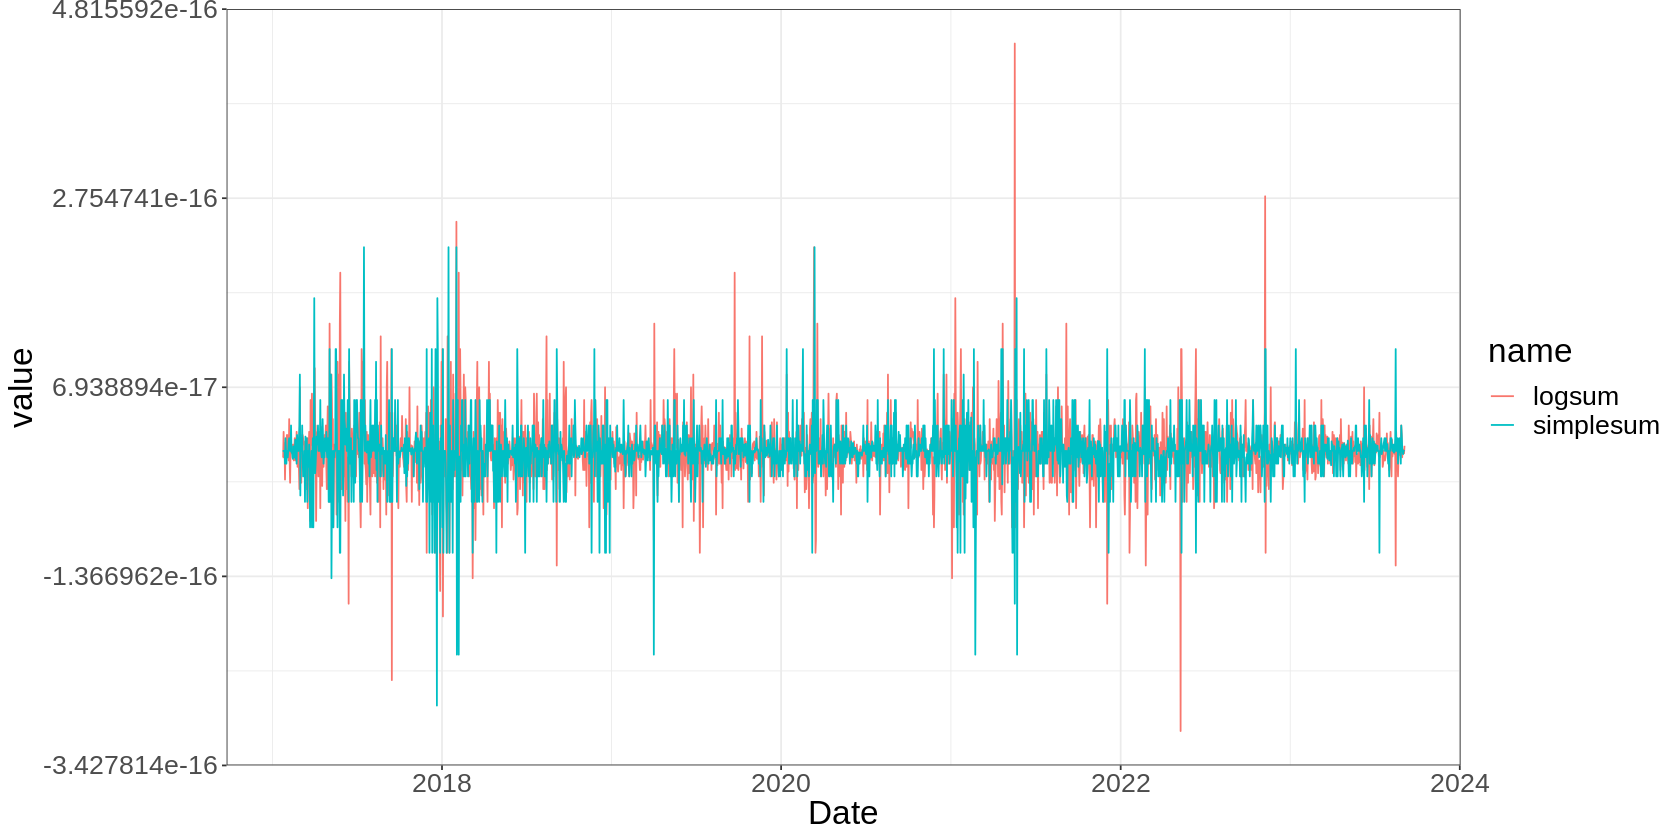

In [46]:
demeaned_returns %>%
  group_by(Date) %>%
  summarise(
    logsum = sum(demeaned_fwd_log_return),
    simplesum = sum(demeaned_fwd_simple_return)
  ) %>%
  pivot_longer(-Date) %>%
  ggplot(aes(x=Date, y=value, color = name)) +
  geom_line()

Just rounding stuff...

Now let's plot de-meaned log return for each rank for each year

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


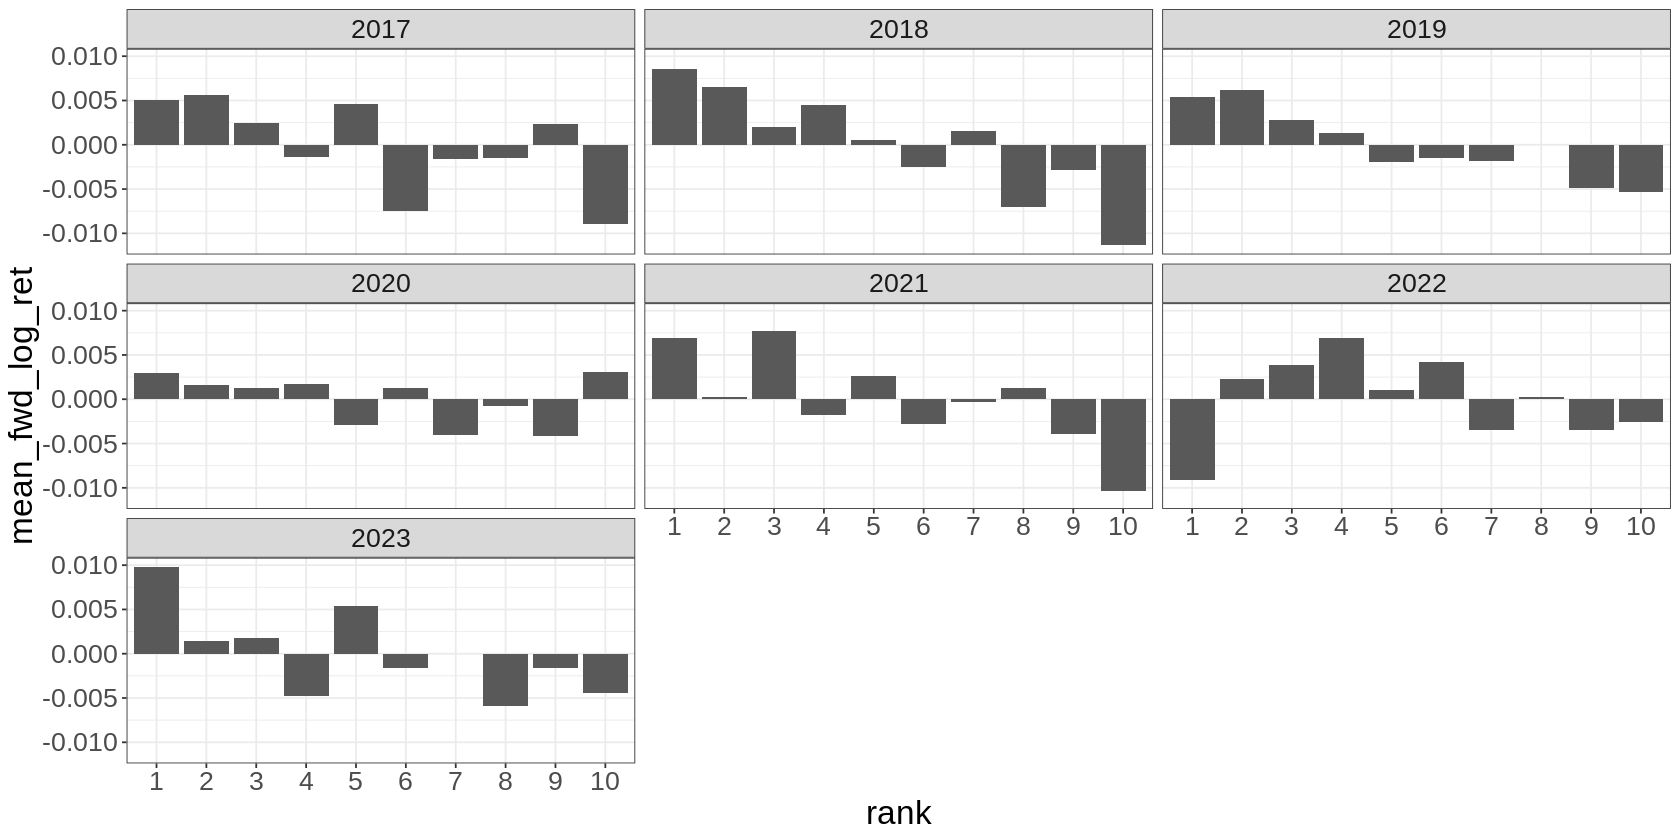

In [47]:
demeaned_returns %>%
  mutate(year = factor(year(Date))) %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(momo20))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(demeaned_fwd_log_return)) %>%
  ggplot(aes(x = rank, y = mean_fwd_log_ret))  +
  geom_bar(stat='identity') +
  facet_wrap(~year)

Daily momentum / reversal effects are a thing. I want to put a day in between our feature and target and see if it impacts anything.

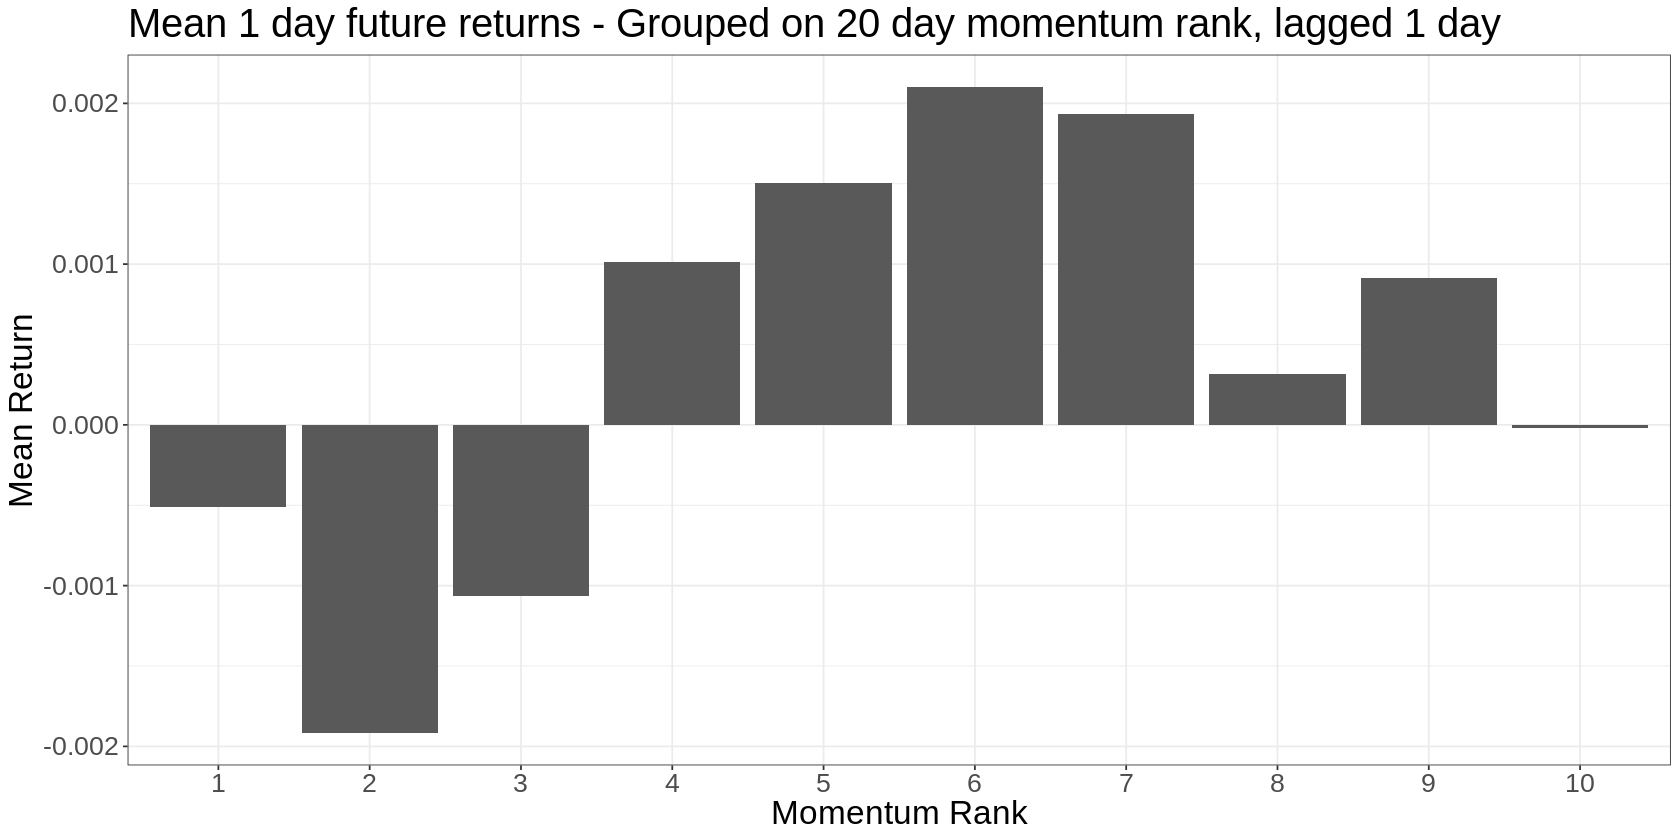

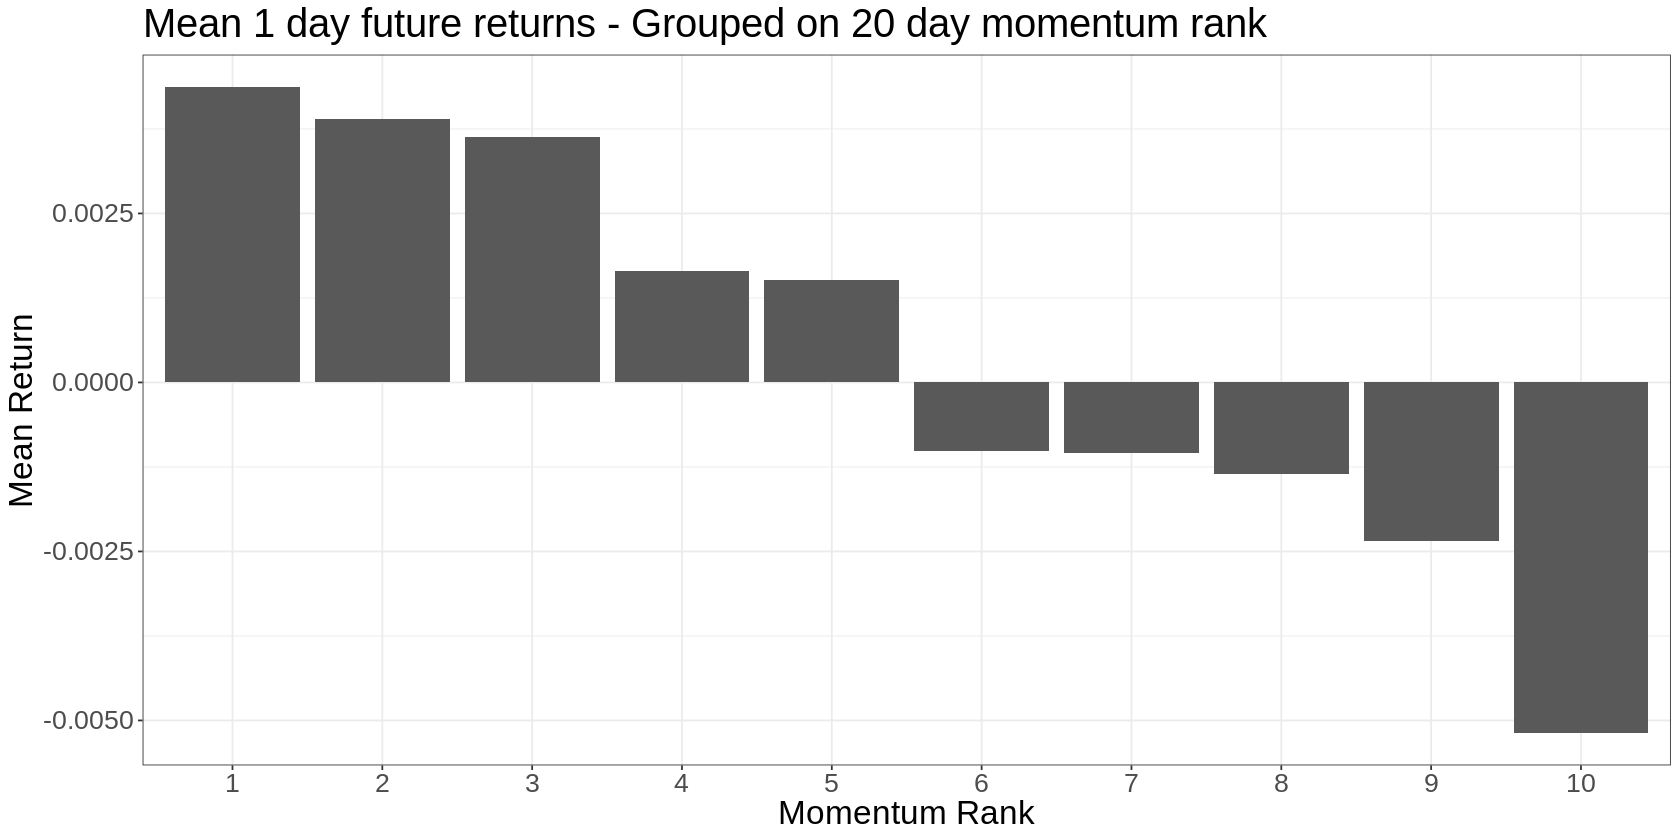

In [61]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(lagrank = factor(row_number(lagmomo20))) %>%
  group_by(lagrank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x = lagrank, y = mean_fwd_log_ret)) +
  geom_bar(stat='identity') +
  labs(
    title = 'Mean 1 day future returns - Grouped on 20 day momentum rank, lagged 1 day',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

  returns %>%
    filter(is_index == TRUE) %>%
    group_by(Date) %>%
    mutate(rank = factor(row_number(momo20))) %>%
    group_by(rank) %>%
    summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
    ggplot(aes(x = rank, y = mean_fwd_log_ret)) +
    geom_bar(stat='identity') +
    labs(
      title = 'Mean 1 day future returns - Grouped on 20 day momentum rank',
      x = 'Momentum Rank',
      y = 'Mean Return'
    )

The top plot (with the extra day between our feature and target) looks much more like the results of our original research.  

This feels a bit fishy - could it be due to the price snapshot being taken at a different time of day?

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


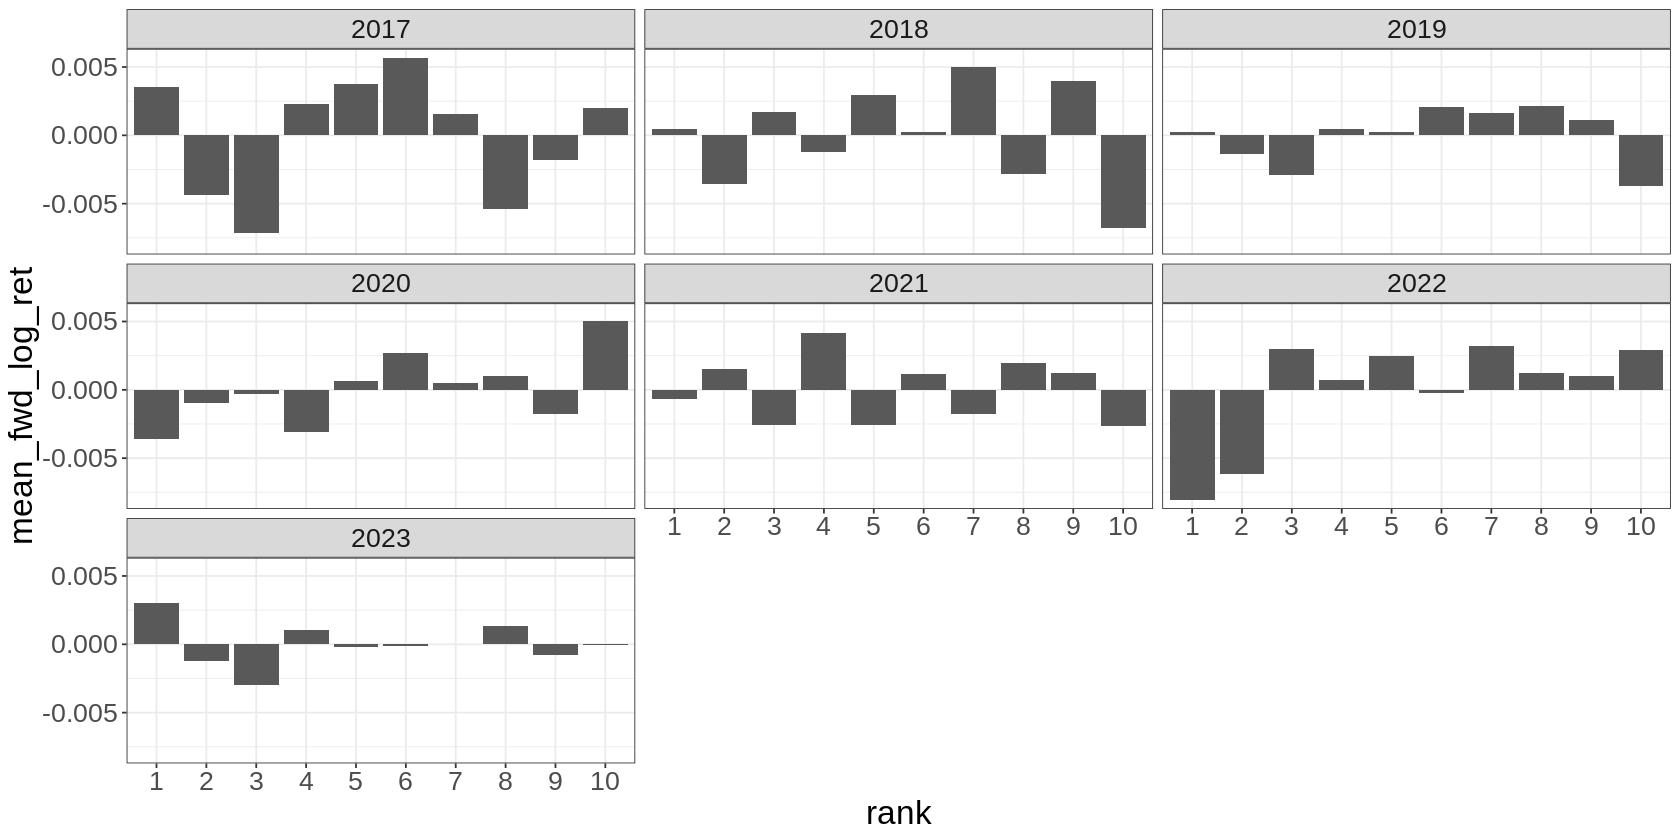

In [62]:
demeaned_returns %>%
  mutate(year = factor(year(Date))) %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(lagmomo20))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(demeaned_fwd_log_return)) %>%
  ggplot(aes(x = rank, y = mean_fwd_log_ret))  +
  geom_bar(stat='identity') +
  facet_wrap(~year)

# Creating a factor time series

Now, we're going to construct a number of factor time series.

1. Top decile - bottom decile
2. Weight all assets in proportion to rank - mean(rank)
3. Weight all assets in proportion to zscore


## 1: Top - Bottom Decile Factor Plot

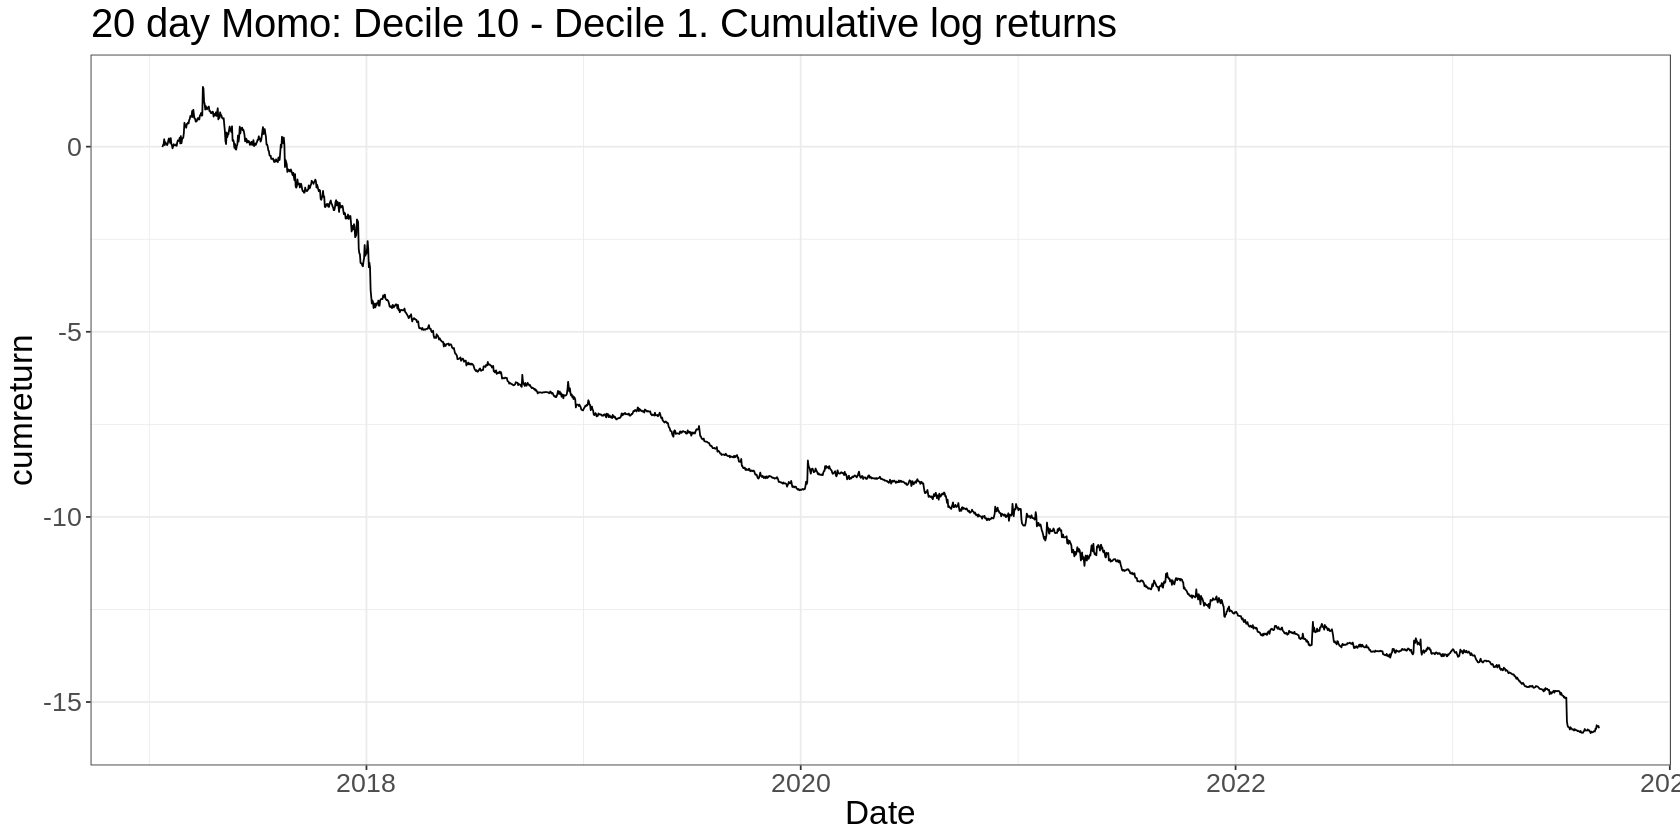

In [84]:
top_ranked <- returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(rank = row_number(momo20)) %>%
  filter(rank == max(rank)) %>%
  select(Date, top_return = fwd_simple_return)

bottom_ranked <- returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(rank = row_number(momo20)) %>%
  filter(rank == min(rank)) %>%
  select(Date, bottom_return = fwd_simple_return)

top_ranked %>%
  inner_join(bottom_ranked, by = 'Date') %>%
  mutate(
    factor_return = (top_return - bottom_return)/2,
    log_factor_return = log(1 + factor_return)
  ) %>%
  ungroup() %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=Date, y=cumreturn)) +
    geom_line() +
    ggtitle('20 day Momo: Decile 10 - Decile 1. Cumulative log returns')

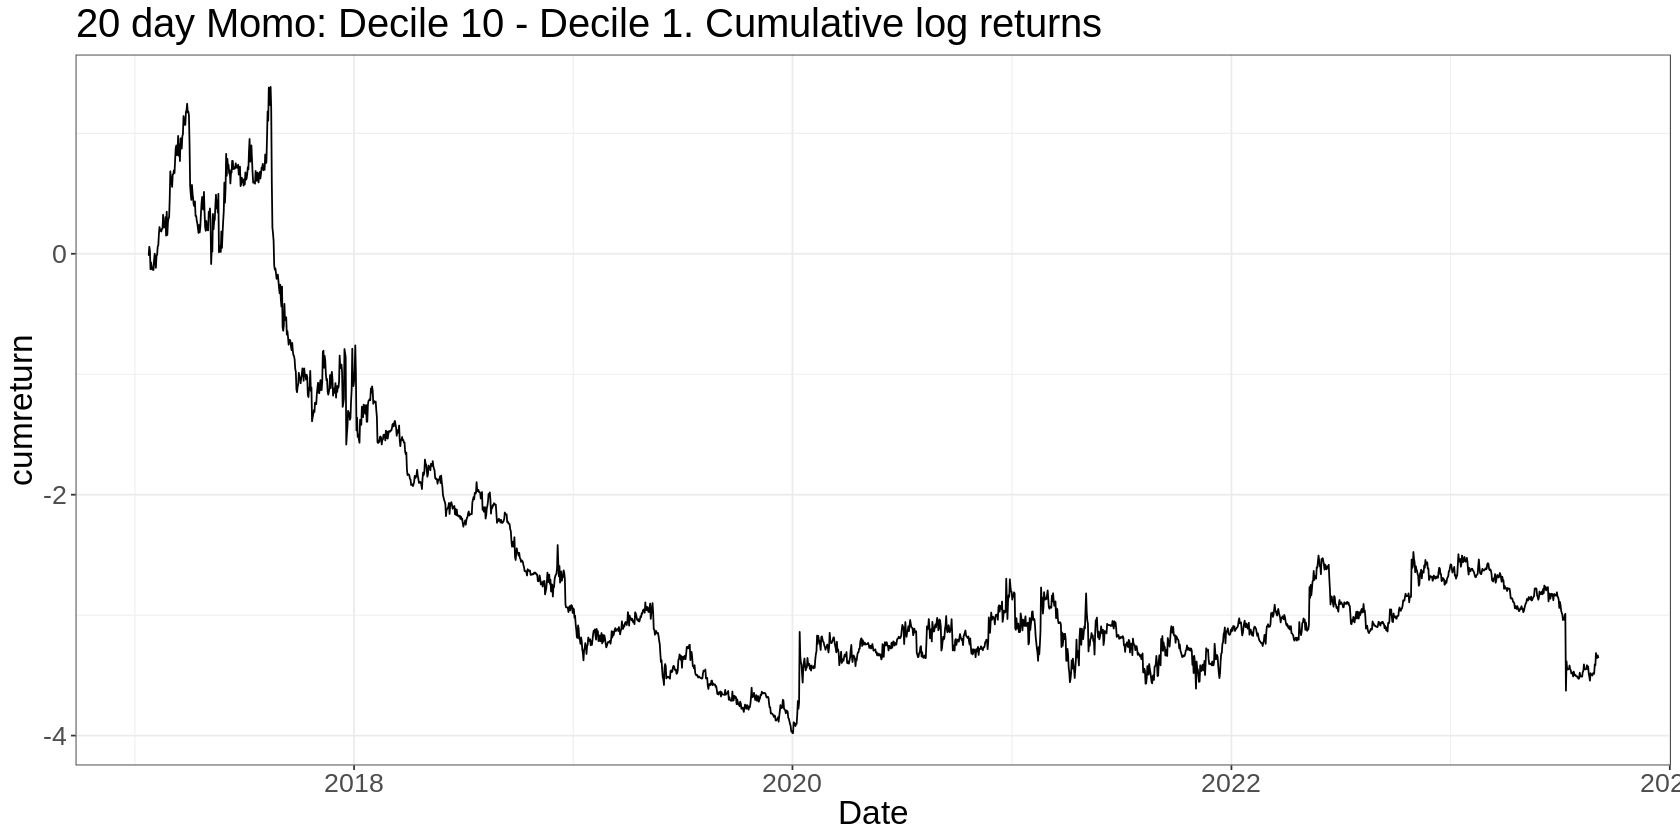

In [87]:
top_ranked <- returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(rank = row_number(lagmomo20)) %>%
  filter(rank == max(rank)) %>%
  select(Date, top_return = fwd_simple_return)

bottom_ranked <- returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(rank = row_number(lagmomo20)) %>%
  filter(rank == min(rank)) %>%
  select(Date, bottom_return = fwd_simple_return)

top_ranked %>%
  inner_join(bottom_ranked, by = 'Date') %>%
  mutate(
    factor_return = (top_return - bottom_return)/2,
    log_factor_return = log(1 + factor_return)
  ) %>%
  ungroup() %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=Date, y=cumreturn)) +
    geom_line() +
    ggtitle('20 day Momo: Decile 10 - Decile 1. Cumulative log returns')

This looks really different to our original research.  

I wonder if the timing of the daily price snapshot could induce this reversal effect.  

I'll repeat this analysis but use the hourly binance data and look at what happens if we take our snapshot at different times.